# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $w$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    return np.array(np.sin(2*w))

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)#рандомная инициализация

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

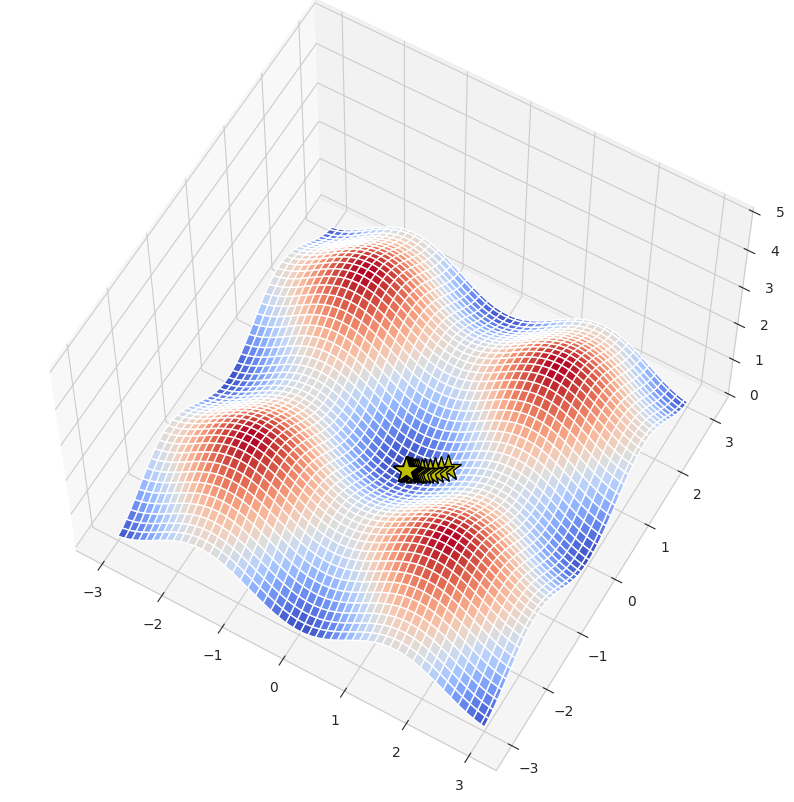

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

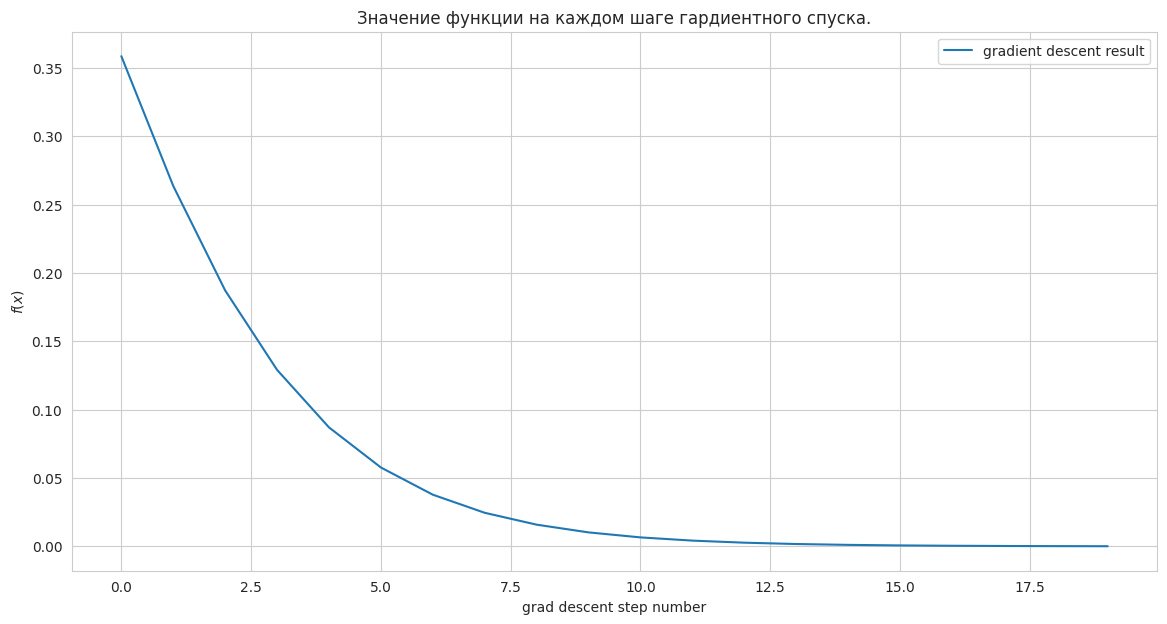

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.sum((y_true - y_pred) ** 2) / y_true.shape[0]


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return 2 / y_true.shape[0] * (np.transpose(X) @ (y_pred - y_true))


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):#считает грациент MSE на конкретном шаге
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):#выбор нормы градиента
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):#по сути надо подобрать омеги
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):#предикт мы берём и в обучение, и в непосредственное предсказание
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return X_test @ self.W
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

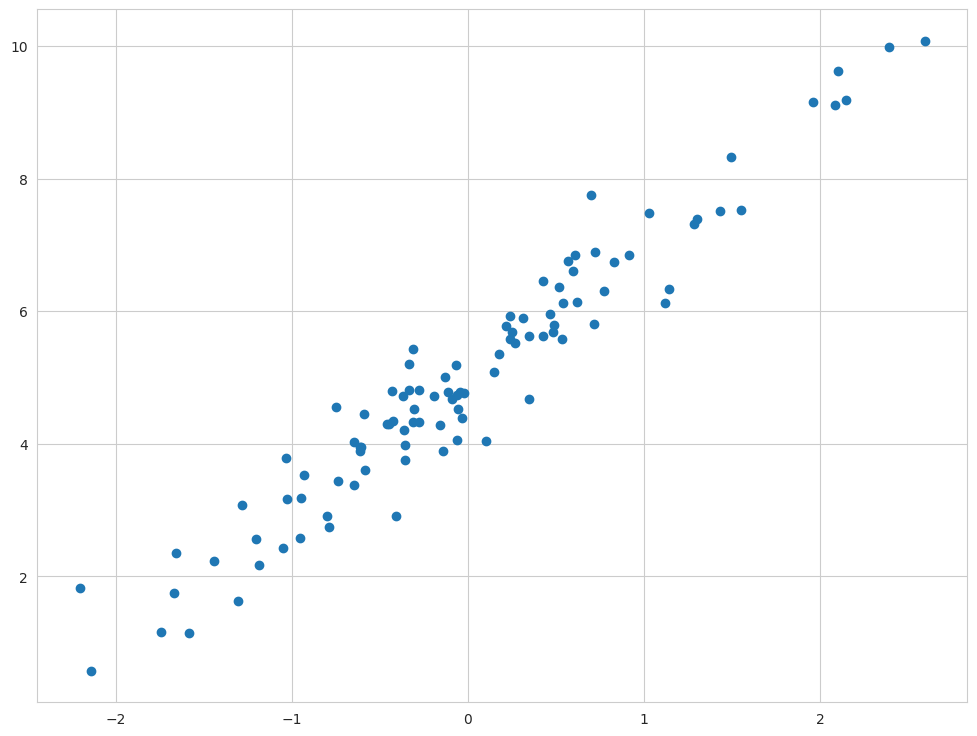

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

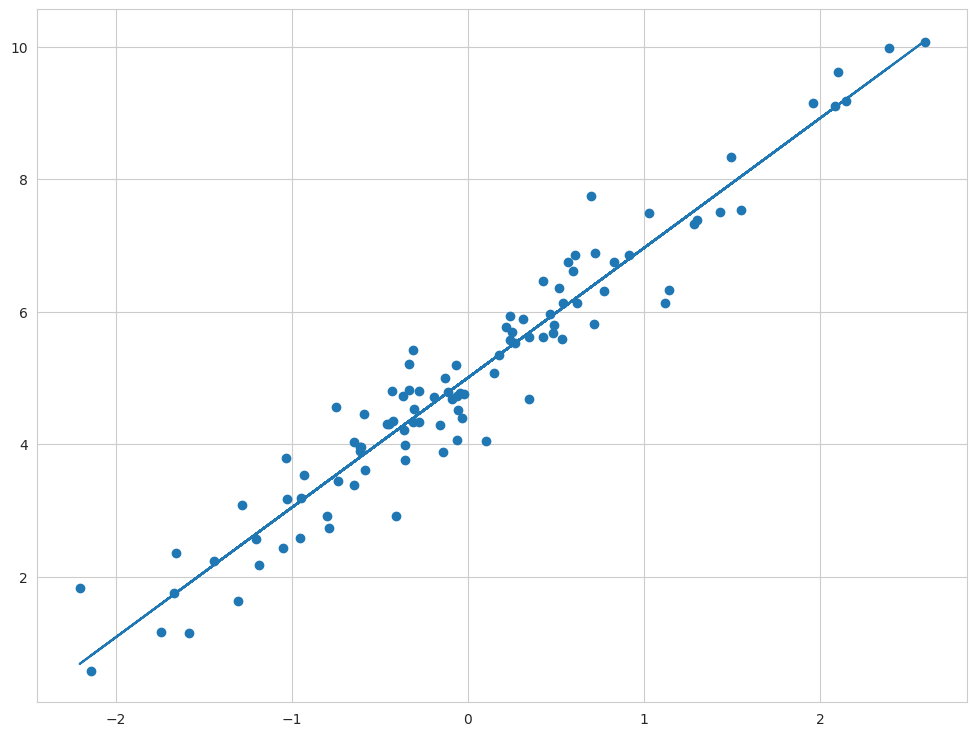

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

**Глянем на пояснения к данным и на сами данные:**

In [20]:
#Пояснения по датафрейму
print(data['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [21]:
df = pd.DataFrame(data.data, columns = feature_names)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [22]:
#глянем на типы данных
df.dtypes

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

*Колонки числовые (и по смыслу, и по данным в df) => если будем стандартизовать, то можно на все колонки*

In [23]:
#Краткая сводка
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


*Видно, что данные не стандартизованы (ну это ещё при df.head было видно кнш) => Будем стандартизовать*

*Среднее количество комнат в 141.9 и спальных 34.1 немного напрягает, но потом глянем на боксплотах (может там много такого).*

In [24]:
#небольшая сводочка
print(f'Строк {df.shape[0]} и колонок {df.shape[1]}')
#Кол-во NA
print(f'Количество NA: {(df.isnull().sum()).sum()}')
#Дубликаты
print(f'Количество дубликатов: {(df[df.duplicated()]).shape[0]}')

Строк 20640 и колонок 8
Количество NA: 0
Количество дубликатов: 0


*Нет NA и дубликатов. Чистить от не от чего*

**Визуализация данных**

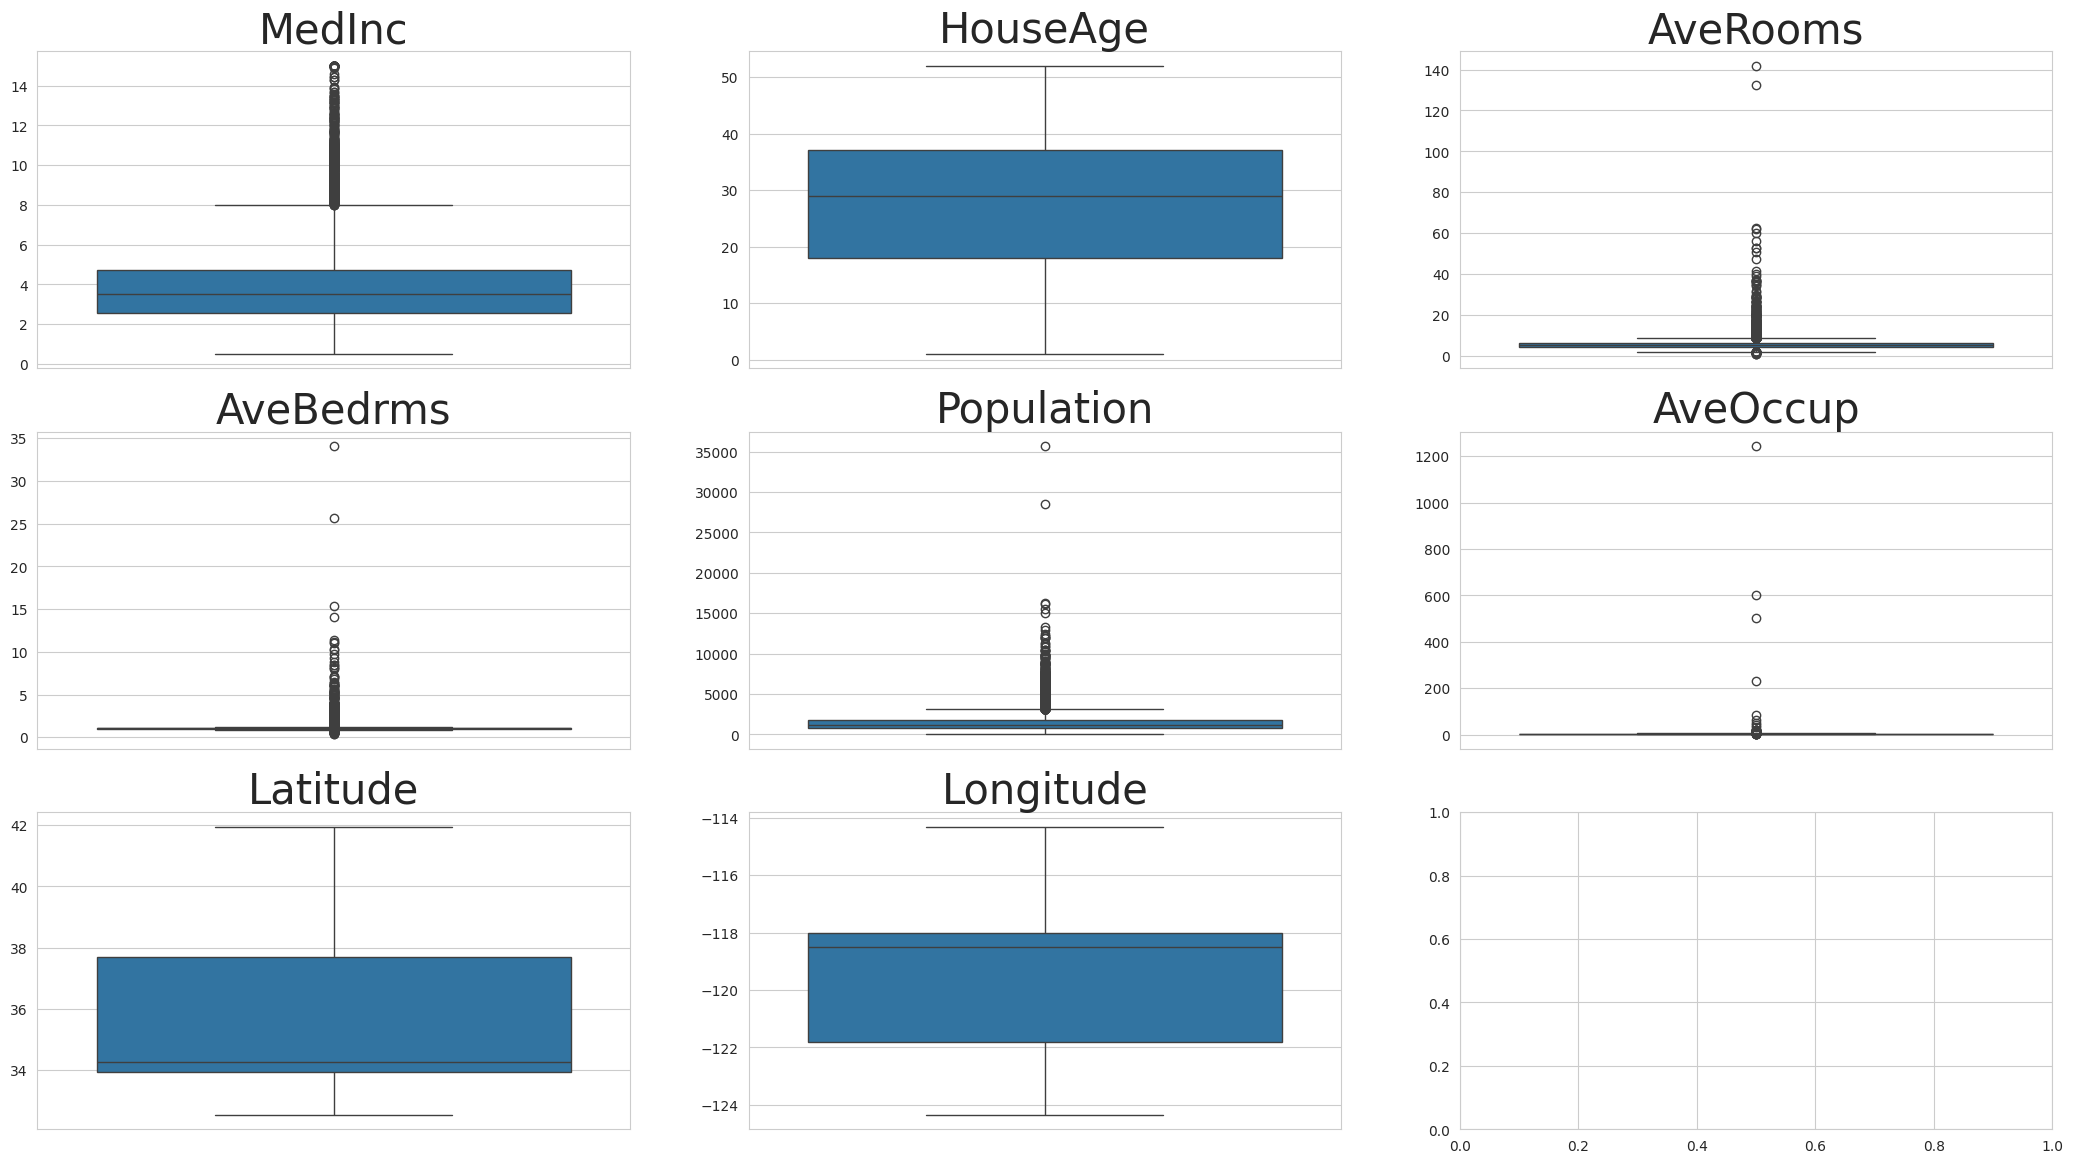

In [25]:
#посмотрим боксплоты:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (26, 14))
axes = axes.ravel()
for col, ax in zip(df.columns, axes):
  sns.boxplot(y = df[col], ax=ax)
  ax.set_title(col, size = 30)
  ax.set(xlabel='', ylabel='')

*У medinc, averms, avebedrms, population, aveoccup видны выбросы. Но в описании к датасету (см ячейку "пояснения по датасету") сказано, что значения могут принимать экстремальные значения из-за курортной инфраструктуры. Так что в целом логично, что может быть отель, где много комнат, спален, приносит много денег, а "население" зависит от сезона. Пока всё оставим.*

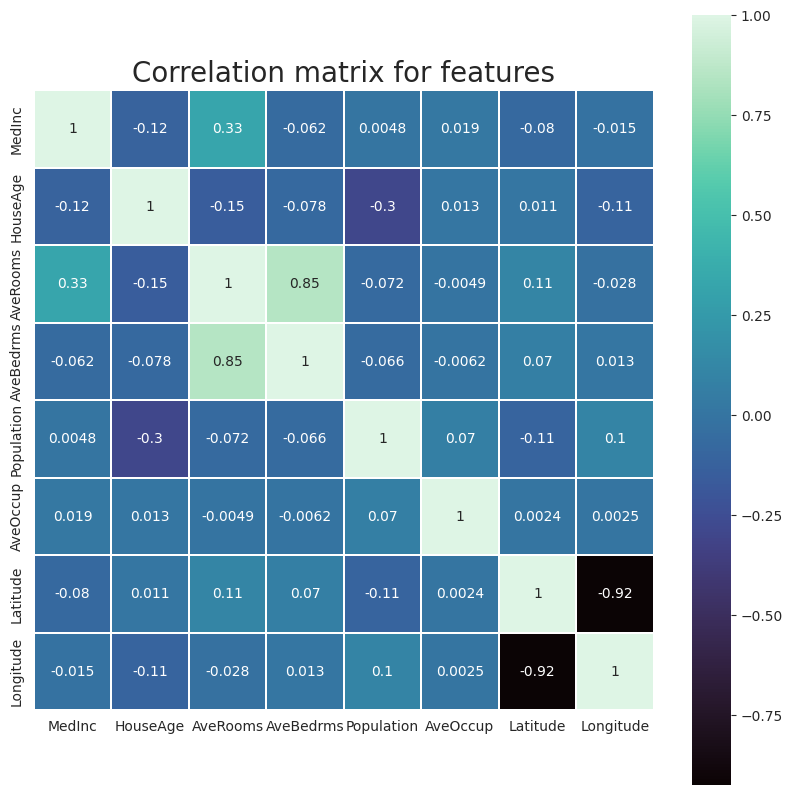

In [26]:
#корреляции
correlations = df.corr() 
plt.figure(figsize = (10,10))
sns.heatmap(correlations, square = True, annot = True, linewidths = 0.25, cmap = 'mako')
plt.title("Correlation matrix for features", size = 20)
plt.show()

*Видим высокие значения корреляции у таких пар фичей как широта/долгота и кол-во комнат/спален. Второе точно логично, поэтому можно убрать колонку с кол-вом спален (при желании можно сделать сколько угодно спален, но не больше чем комнат =D). С долготой/широтой сложнее. Если на карте посмотреть, то Калифорния по диагонали растянулась. Предлагаю выкинуть один столбец из пары, т.к. (анти)корреляция большая, а смысла не так много.*

In [27]:
df_to_model = df.drop(['AveBedrms', 'Latitude'], axis =1)
X_to_model = df_to_model.to_numpy()

In [28]:
df.drop(['AveBedrms', 'Latitude'], axis =1)

,MedInc,HouseAge,AveRooms,Population,AveOccup,Longitude
0,8.3252,41.0,6.984127,322.0,2.555556,-122.23
1,8.3014,21.0,6.238137,2401.0,2.109842,-122.22
2,7.2574,52.0,8.288136,496.0,2.802260,-122.24
3,5.6431,52.0,5.817352,558.0,2.547945,-122.25
4,3.8462,52.0,6.281853,565.0,2.181467,-122.25
...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,845.0,2.560606,-121.09
20636,2.5568,18.0,6.114035,356.0,3.122807,-121.21
20637,1.7000,17.0,5.205543,1007.0,2.325635,-121.22
20638,1.8672,18.0,5.329513,741.0,2.123209,-121.32


**Построение модели**

In [29]:
#тест/трейн сплит
X_train, X_test, y_train, y_test = train_test_split(
    X_to_model, y, test_size=0.2, random_state = SEED)

print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

Train: 16512	Test: 4128


In [30]:
#стандартизация
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
#линейная регрессия
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [32]:
#метрики
print(f'Mean square error = {(mean_squared_error(y_true = y_test, y_pred = y_pred)):1.3f}\nR-Square = {(r2_score(y_true = y_test, y_pred = y_pred)):1.3f}')

Mean square error = 0.673
R-Square = 0.497


*mse (чем меньше, тем лучше) маленькая, R2 (чем больше тем лучше) ну почти 0,5.*

MedInc 0.842
HouseAge 0.223
AveRooms -0.058
AveOccup -0.05
Population 0.032
Longitude -0.021


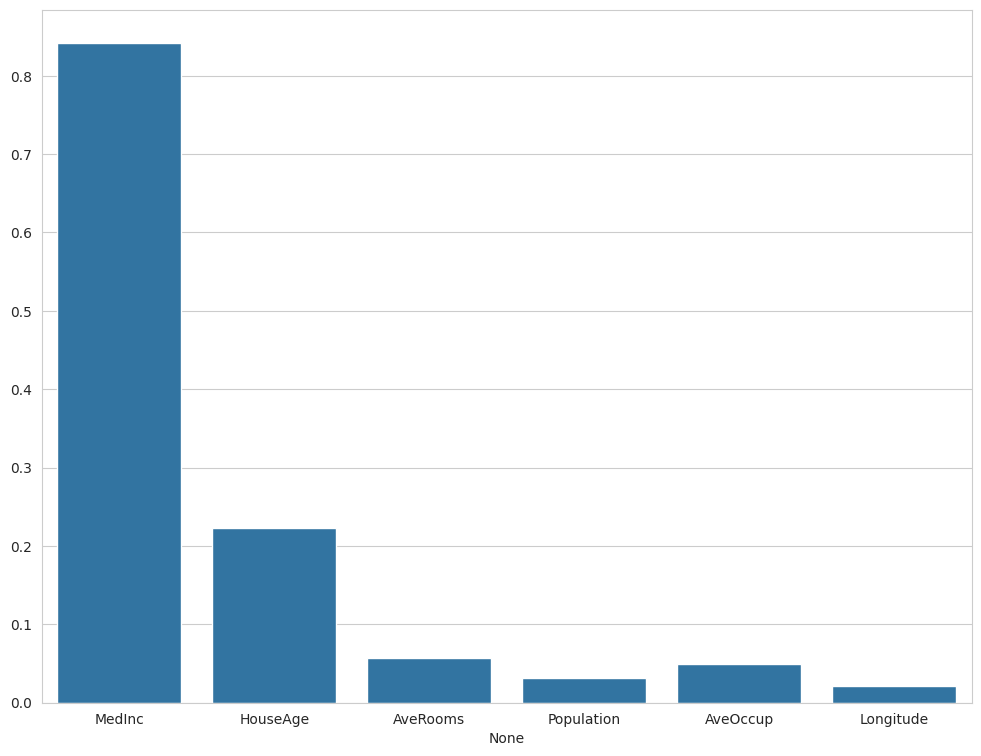

In [33]:
#чекнем коэффициенты
model_feature = df_to_model.columns
indexes = np.argsort(np.abs(lr.coef_), )[::-1]

for index in indexes:
    print(model_feature[index], np.round(lr.coef_[index], 3))

sns.barplot(x = model_feature, y = np.abs(lr.coef_));

*Получилось, что доходы самые значимые, что логично. Сколько заработал, на то и купил (мало заработал, купил по низкой цене, много - по большой). На втором месте, но с большим отрывом, возраст постройки. Что тоже логично (есть конечно древние замки, которые стоят оооч много, но это же Калифорния там старое это старое, а не элитное, наверное)*

*Интересно глянуть модель, в которой всё оставить и построить так*

Mean square error =      0.541
R-Square =      0.596

MedInc 0.828
HouseAge 0.122
AveRooms -0.261
Population -0.007
AveBedrms 0.305
AveOccup -0.04


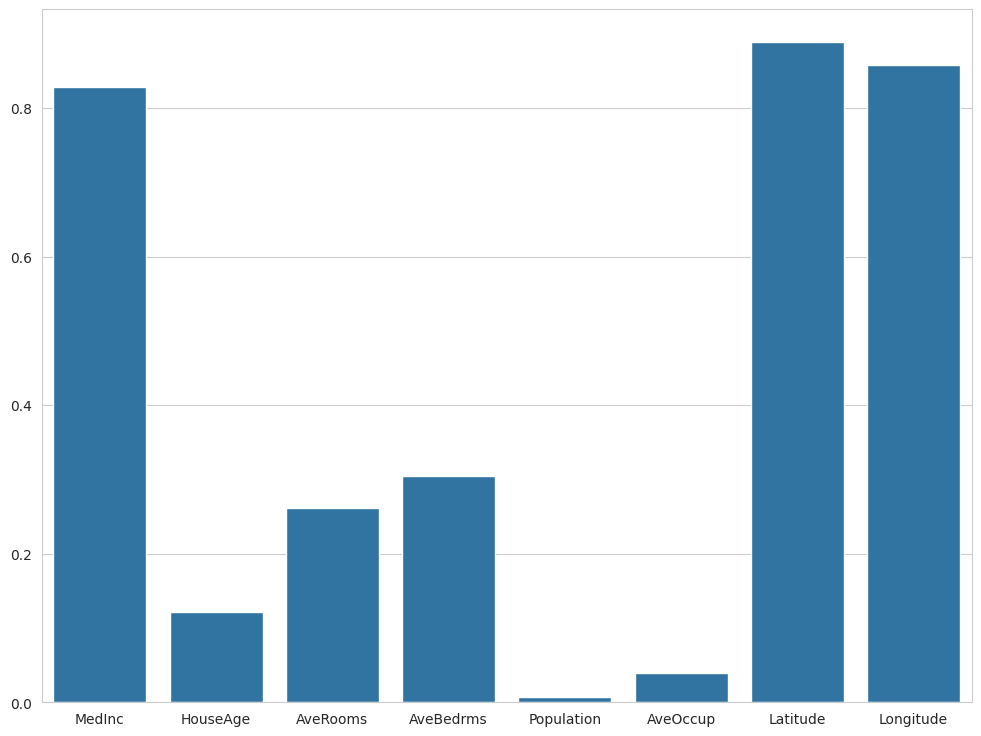

In [34]:
X, y = data["data"], data["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = SEED)#сплитим исходный X

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)
y_pred = lr_raw.predict(X_test)

print(f'Mean square error = {(mean_squared_error(y_true = y_test, y_pred = y_pred)):10.3f}\nR-Square = {(r2_score(y_true = y_test, y_pred = y_pred)):10.3f}\n')

model_feature = feature_names
indexes = np.argsort(np.abs(lr.coef_), )[::-1]
for index in indexes:
    print(model_feature[index], np.round(lr_raw.coef_[index], 3))
sns.barplot(x = feature_names, y = np.abs(lr_raw.coef_));

*MSE вышла ниже, R2 выше, что вообще-то говорит о том, что можель лучше. Но если посмотреть на коэффициенты. то видно, что для широты/долготы коэффициенты рядом по значению, что ожидаемо для скоррелированных фичей и не совсем правильно для модели. Возможно, стоило бы попробовать сконструировать из них какую-то одну общую фичу (как раз дагональ по типу sqrt(x*x+y*y)*

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [35]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1 / (1 + np.exp(-output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [36]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)#Clip (limit) the values in an array.
    
    return 1 / n * (-np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)))
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.transpose(X) @ (y_pred - y_true)


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [37]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return sigmoid(X_test @ self.W)

    def predict_class(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))

        probability = sigmoid(X_test @ self.W)
            
        return np.where(probability > 0.5, 1, 0)
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [38]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

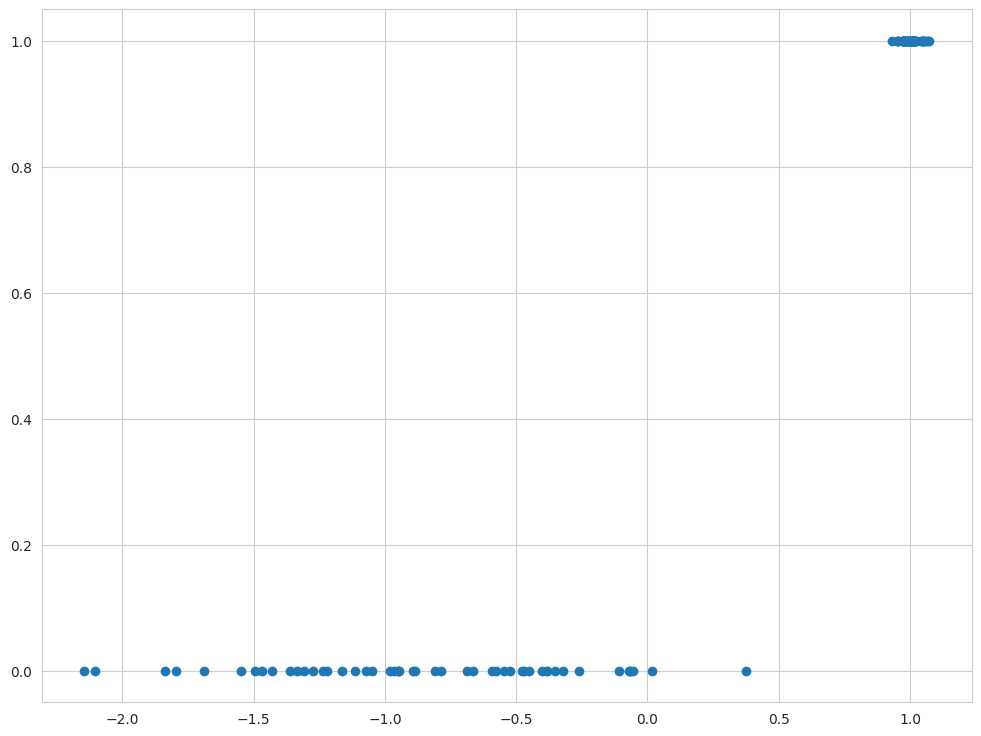

In [39]:
plt.scatter(X, y);

In [40]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

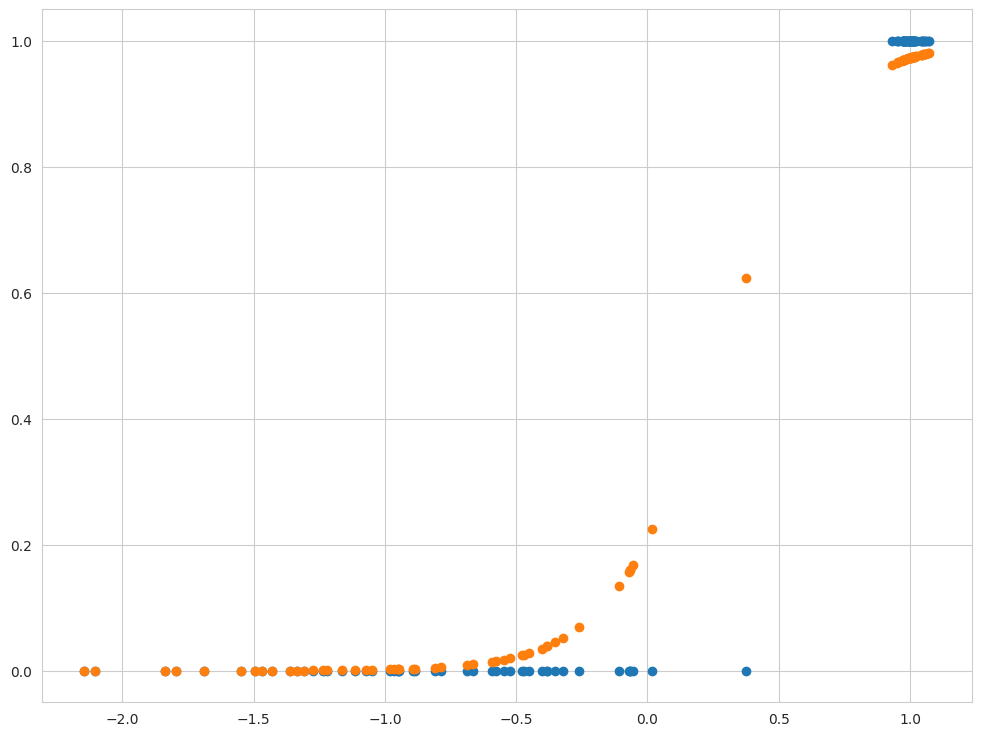

In [41]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

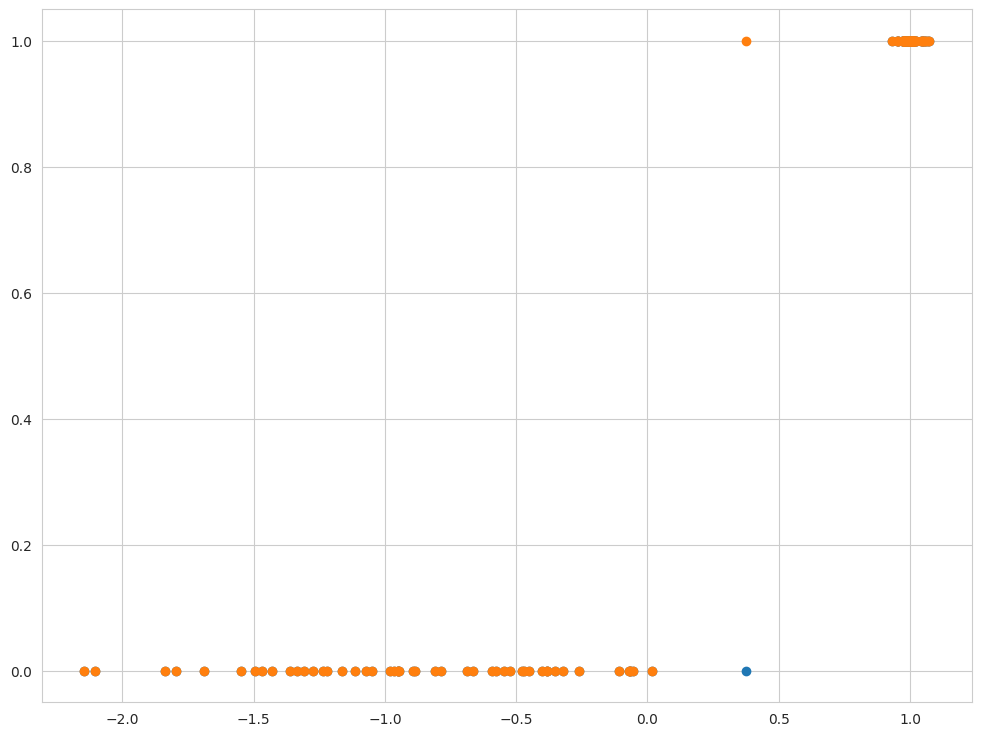

In [42]:
plt.scatter(X, y)
plt.scatter(X, custom_log_reg.predict_class(X));

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [43]:
#Мы предсказывали вероятность. Для метрик бинарной классификации нужно перевести значения в класс. 
#для этого возьмём границу в 0,5
y_pred_class = np.where(y_pred > 0.5, 1, 0)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f'Accuracy = {accuracy_score(y, y_pred_class):1.3f}\nPrecision = {precision_score(y, y_pred_class):1.3f}\nRecall = {recall_score(y, y_pred_class):1.3f}\nF1-score = {f1_score(y, y_pred_class):1.3f}')

Accuracy = 0.990
Precision = 0.980
Recall = 1.000
F1-score = 0.990


In [44]:
#для вероятностей есть ROC AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y, y_pred)

1.0

*Видим, что наши метрики (все 5) близки к 1, что для всех хорошо.*

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [45]:
pokemon = pd.read_csv("../data_folder/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Датасет:

* #: ID for each pokemon
* Name: Name of each pokemon
* Type 1: Each pokemon has a type, this determines weakness/resistance to attacks
* Type 2: Some pokemon are dual type and have 2
* Total: sum of all stats that come after this, a general guide to how strong a pokemon is
* HP: hit points, or health, defines how much damage a pokemon can withstand before fainting
* Attack: the base modifier for normal attacks (eg. Scratch, Punch)
* Defense: the base damage resistance against normal attacks
* SP Atk: special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)
* SP Def: the base damage resistance against special attacks
* Speed: determines which pokemon attacks first each round

*Сразу можно сказать, что стоит удалить столбцы # и Name, т.к. это как идентификаторы покемонов и от них не должен зависеть результат.*

*Также что-то нужно будет делать со 2 типом, т.к. он есть не у всех и это будут NA.*

*Ещё есть колонка Total, которая чумма двух атак и двух 2 защит. Глянем на корреляции потом что там с ними, но понятно, что связь есть.*

In [46]:
#сразу дропнем # и Name
pokemon = pokemon.drop(['#', 'Name'], axis = 1)
pokemon.head(3)

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Grass,Poison,525,80,82,83,100,100,80,1,False


This dataframe has 800 samples (rows) and 11 columns (variables)

This dataframe contains:
7 numeric variables: Total, HP, Attack, Defense, Sp. Atk, Sp. Def, Speed
4 factor variables: Type 1, Type 2, Generation, Legendary

Statistic for factor variables:

---- Type 1 ---


,value,count,frequency
0,Water,112,0.14000
1,Normal,98,0.12250
2,Grass,70,0.08750
3,Bug,69,0.08625
4,Psychic,57,0.07125
5,Fire,52,0.06500
6,Electric,44,0.05500
7,Rock,44,0.05500
8,Dragon,32,0.04000
9,Ground,32,0.04000



---- Type 2 ---


,value,count,frequency
0,Flying,97,0.234300
1,Ground,35,0.084541
2,Poison,34,0.082126
3,Psychic,33,0.079710
4,Fighting,26,0.062802
5,Grass,25,0.060386
6,Fairy,23,0.055556
7,Steel,22,0.053140
8,Dark,20,0.048309
9,Dragon,18,0.043478



---- Generation ---


,value,count,frequency
0,1,166,0.20750
1,5,165,0.20625
2,3,160,0.20000
3,4,121,0.15125
4,2,106,0.13250
5,6,82,0.10250



---- Legendary ---


,value,count,frequency
0,False,735,0.91875
1,True,65,0.08125



Statistic for number variables:


,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000




There are 386 NA values in total
They are in 386 rows in this dataframe.
In columns: Type 2

There are 3 duplicated rows in this dataframe.


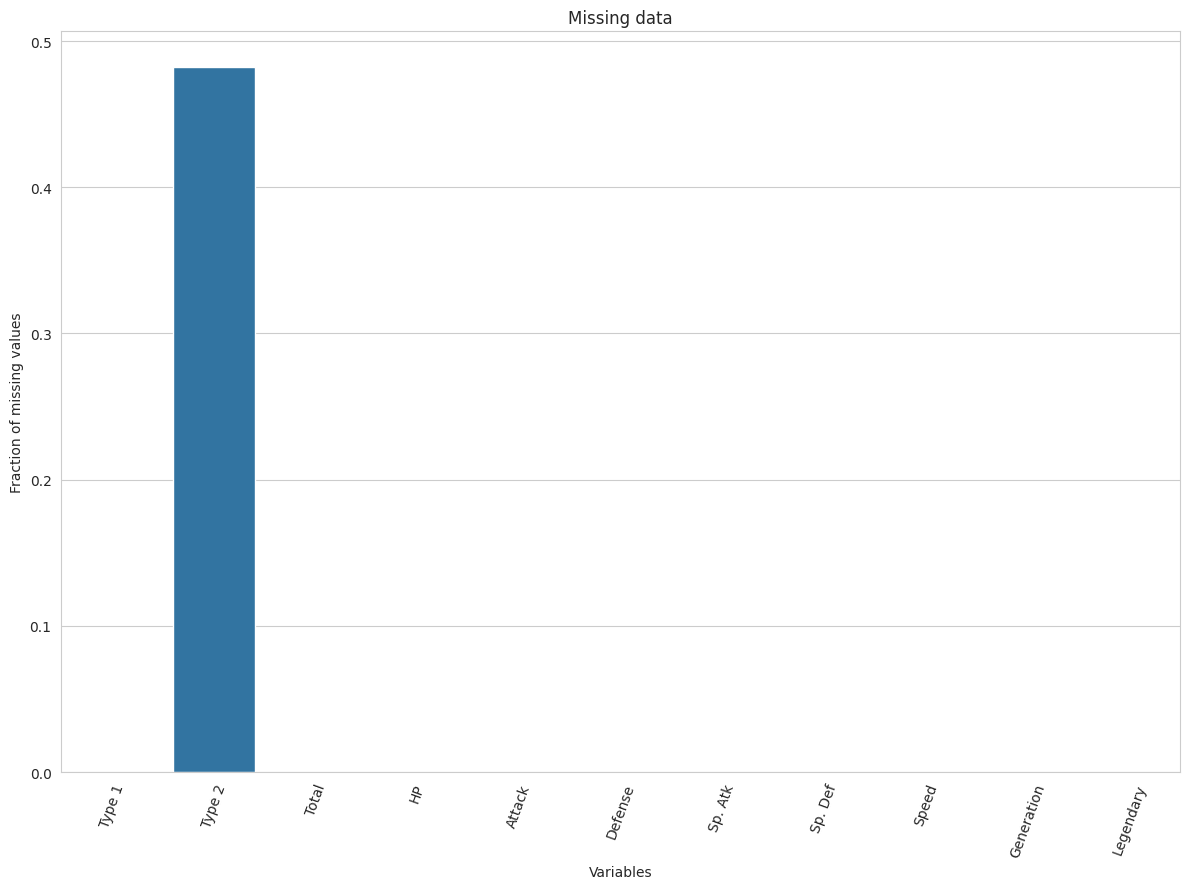

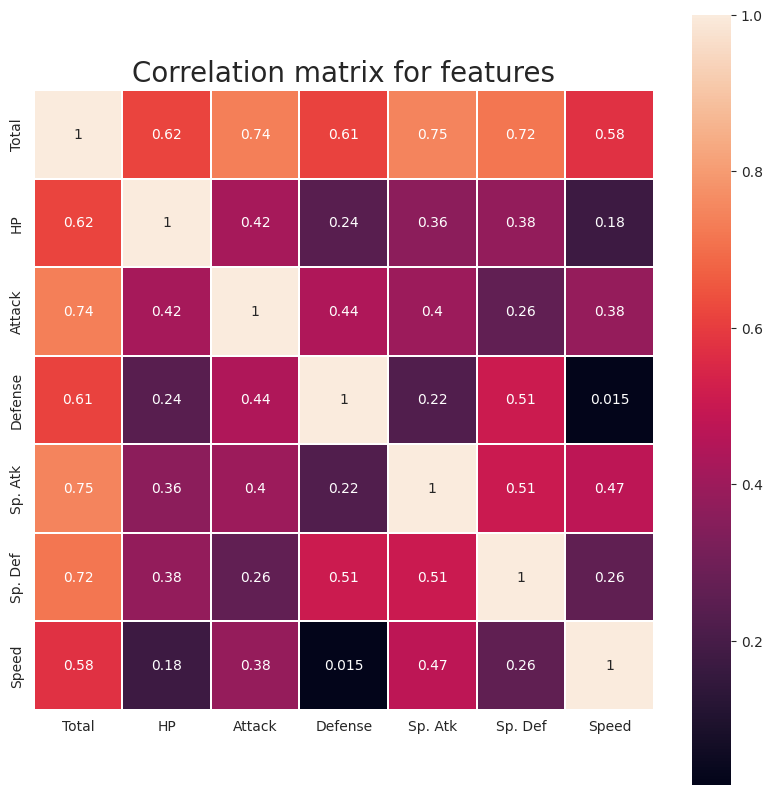

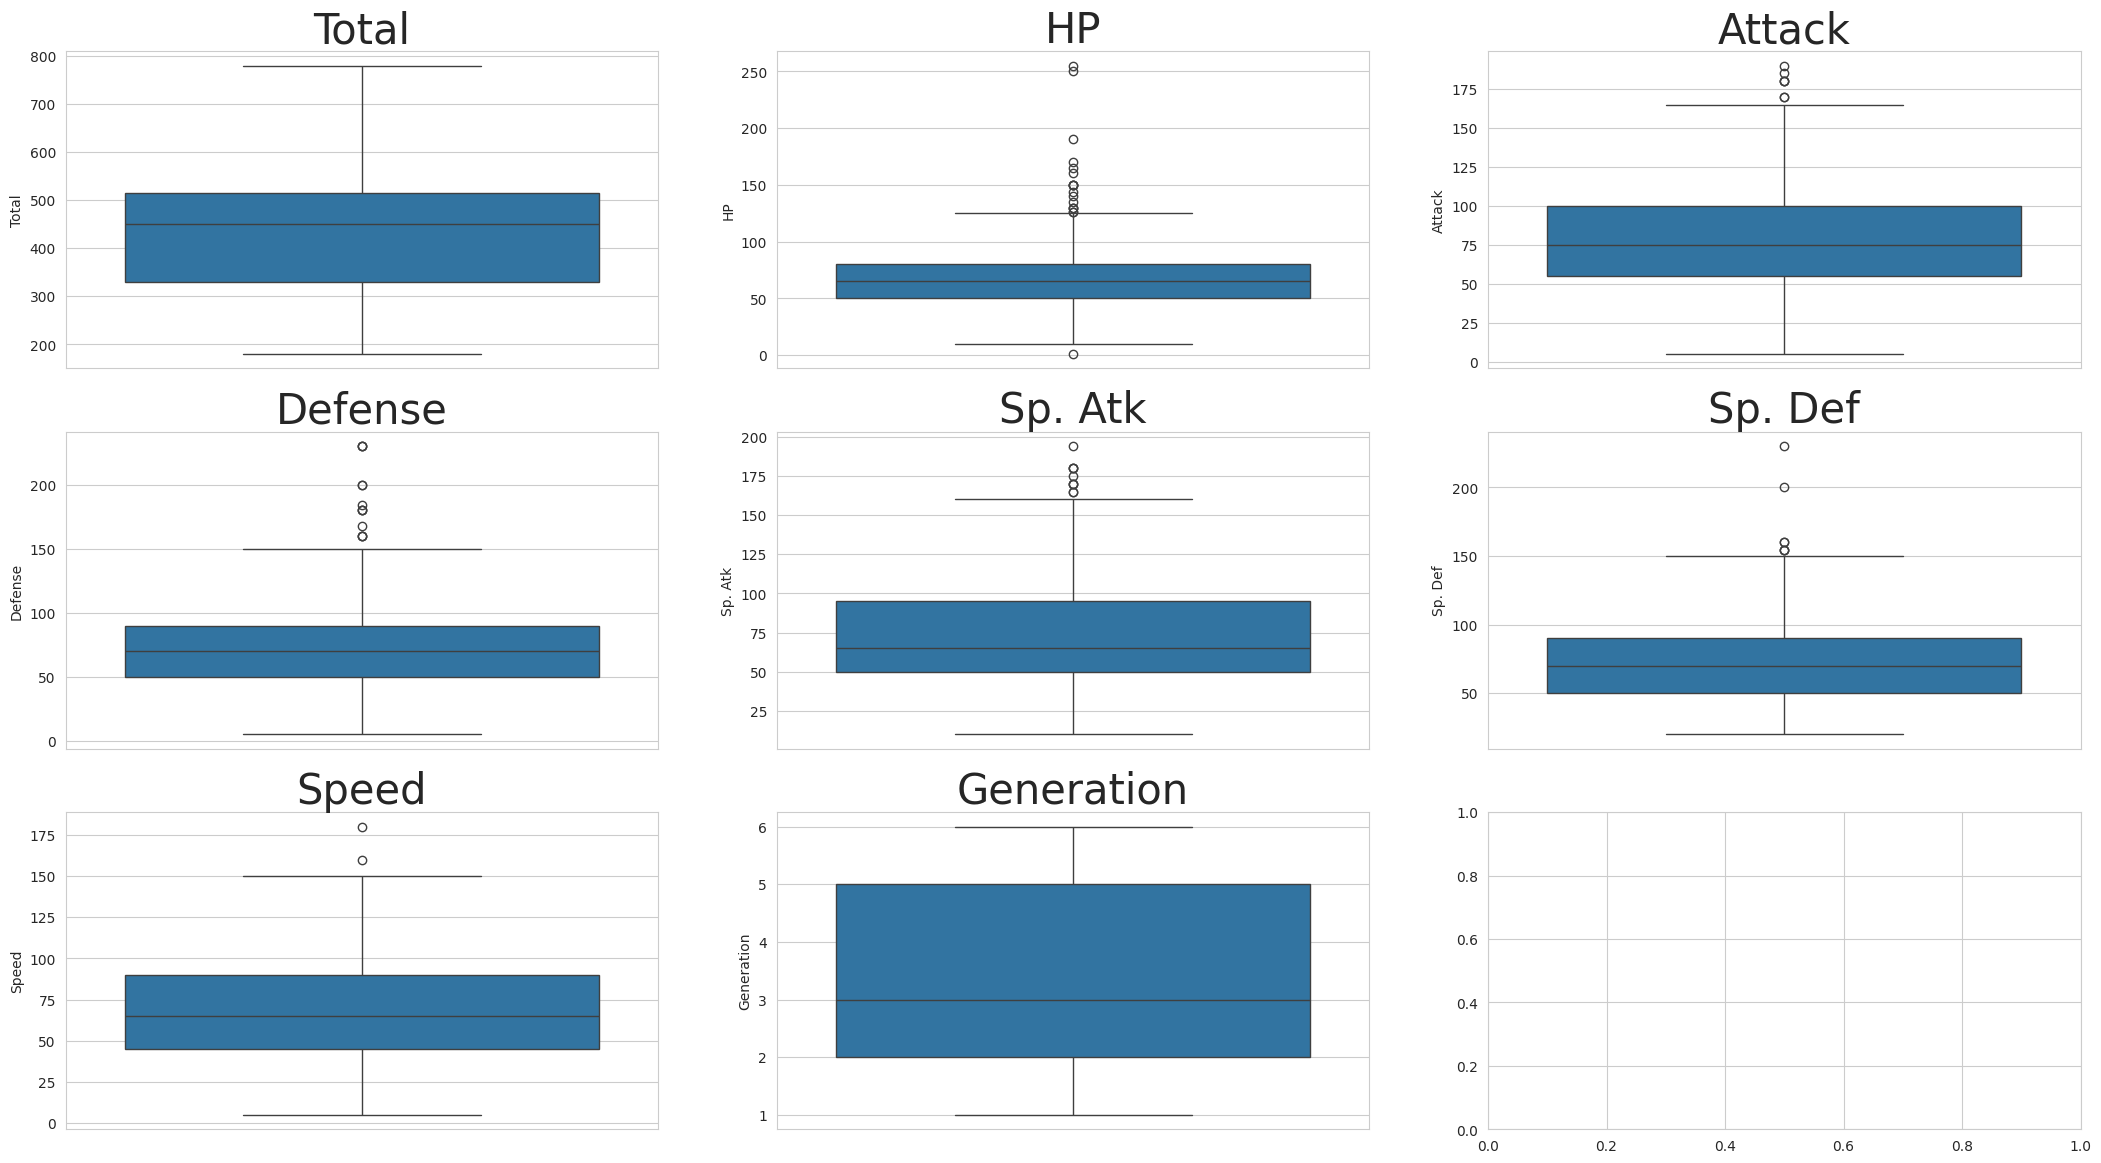

In [47]:
#EDA
from my_awesome_eda import run_eda

run_eda(pokemon)

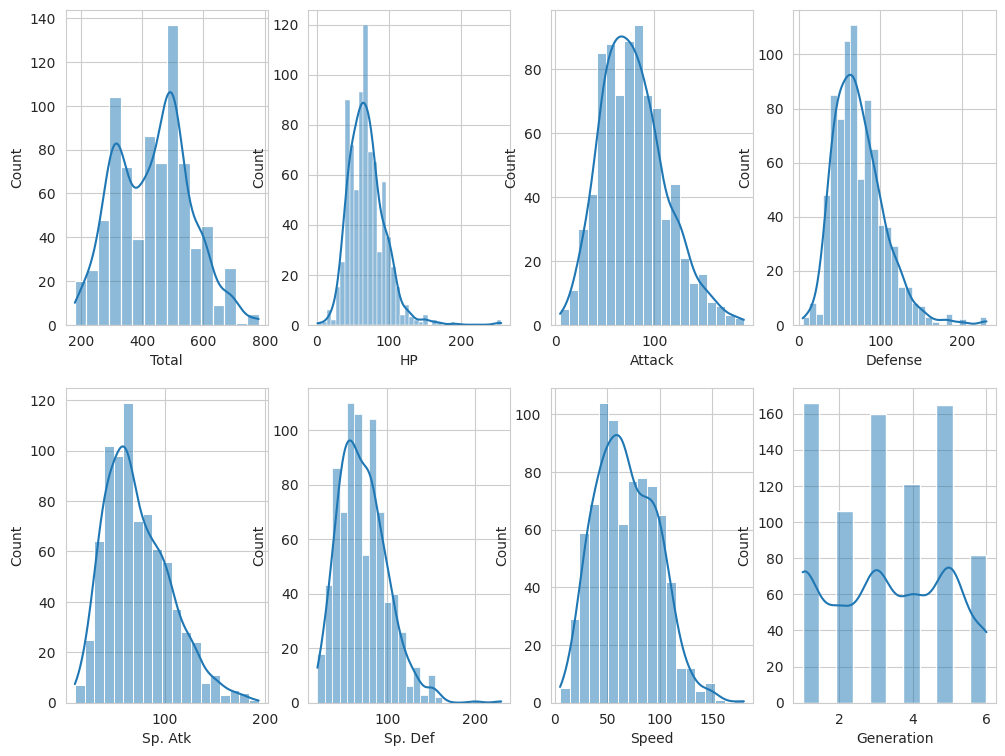

In [48]:
#И дополним Распределениями (если я правильно что требовалось в задании)
numeric_cols = list(pokemon.select_dtypes(include=np.number).columns)

fig, axes = plt.subplots(nrows=2, ncols=4)
for i, column in enumerate(numeric_cols):
    sns.histplot(pokemon[column], ax=axes[i//4, i%4], kde=True)

*Сразу заметим, что Total реально много с чем коррелирует и попробуем его дропнуть дальше*

Итого:

* У нас есть всего 17 типов (категориальная). Но для Type 2 много NA. Можно было бы удалить строчки с NA тут, но тогда потеряется 386/800 ~48% (ну почти половина данных пропадёт). Поэтому мы уберём саму колонку. (можно было бы ещё её заполнить для NA типом 1, но это кажется более бесмысленным, чем просто убрать колонку. 

* Для типа 1 не будем делать one hot encoding. Колонок всё-таки 17. Возрастёт количество фичей, что тоже не всегда хорошо. Но 17 наверно всё-таки не оч много, но пока оставим так. 

* Про Total. Из матрицы корреляции видно, что он много с чем коррелирует (в т.ч.Attack, Defense, Sp. Atk, Sp. Def, как обсуждали выше). Уберём колонку.

In [49]:
#дропаем Type 2 и Total
pokemon = pokemon.drop(['Type 2', 'Total'], axis = 1)
pokemon.head(3)

,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,45,49,49,65,65,45,1,False
1,Grass,60,62,63,80,80,60,1,False
2,Grass,80,82,83,100,100,80,1,False


Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [50]:
#сделаем легендарность 0 1
pokemon['Legendary'] = pokemon['Legendary'].astype(int)
pokemon.head(3)

,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,45,49,49,65,65,45,1,0
1,Grass,60,62,63,80,80,60,1,0
2,Grass,80,82,83,100,100,80,1,0


In [51]:
#Вообще generation должен быть категориальным тоже. Давайте оставим категориальные, но к норм типу их приведём
pokemon['Type 1'] = pokemon['Type 1'].astype('category')
pokemon['Generation'] = pokemon["Generation"].astype('category')

#И сделаем ohe
pokemon = pd.get_dummies(pokemon, columns=['Type 1', 'Generation'], drop_first=True)

In [52]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   HP               800 non-null    int64
 1   Attack           800 non-null    int64
 2   Defense          800 non-null    int64
 3   Sp. Atk          800 non-null    int64
 4   Sp. Def          800 non-null    int64
 5   Speed            800 non-null    int64
 6   Legendary        800 non-null    int64
 7   Type 1_Dark      800 non-null    bool 
 8   Type 1_Dragon    800 non-null    bool 
 9   Type 1_Electric  800 non-null    bool 
 10  Type 1_Fairy     800 non-null    bool 
 11  Type 1_Fighting  800 non-null    bool 
 12  Type 1_Fire      800 non-null    bool 
 13  Type 1_Flying    800 non-null    bool 
 14  Type 1_Ghost     800 non-null    bool 
 15  Type 1_Grass     800 non-null    bool 
 16  Type 1_Ground    800 non-null    bool 
 17  Type 1_Ice       800 non-null    bool 
 18  Type 1_Nor

Разделите ваши данные на тестовую и тренировочную выборку.

In [53]:
#разбивка
X = pokemon.drop('Legendary', axis=1)
y = pokemon['Legendary']
numeric_cols = list(X.select_dtypes(include=np.number).columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = SEED)

In [54]:
#скейлим
scaler = StandardScaler()
#scaler.fit(X_train[numeric_cols])
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

Обучите модель `LogisticRegression` из `sklearn`.

In [55]:
#Модель
clf = LogisticRegression()
clf.fit(X_train, y_train)
#clf = LogisticRegression(random_state = SEED).fit(X_train, y_train)
y_pred = clf.predict(X_test)
#y_pred

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

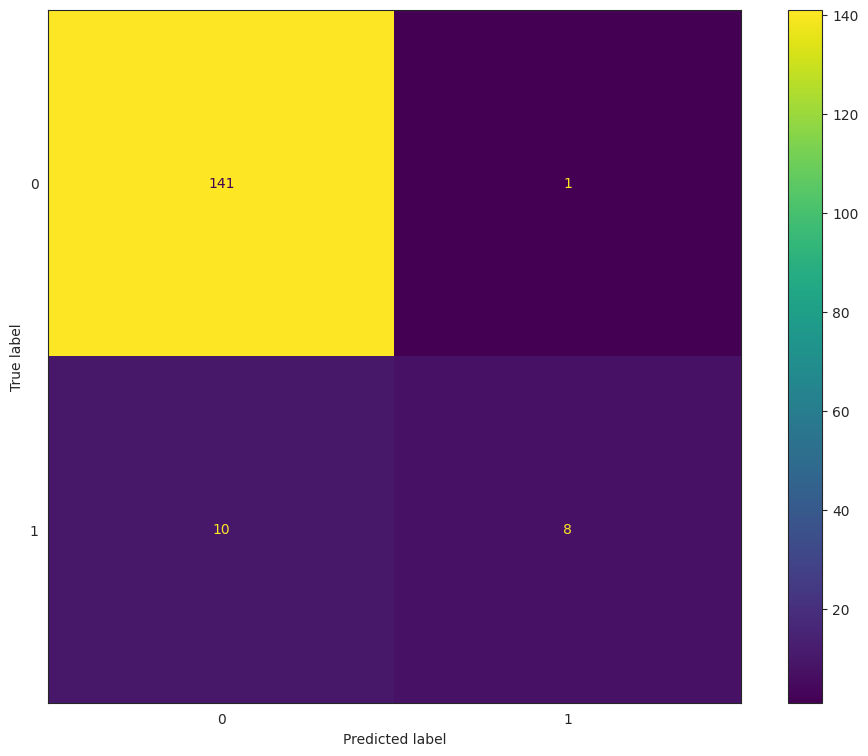

In [56]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_style("white")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

*Много TN получилось (это хорошо), но есть и неправильно определённые. Хотя конечно кажется, что их не так то и много.*

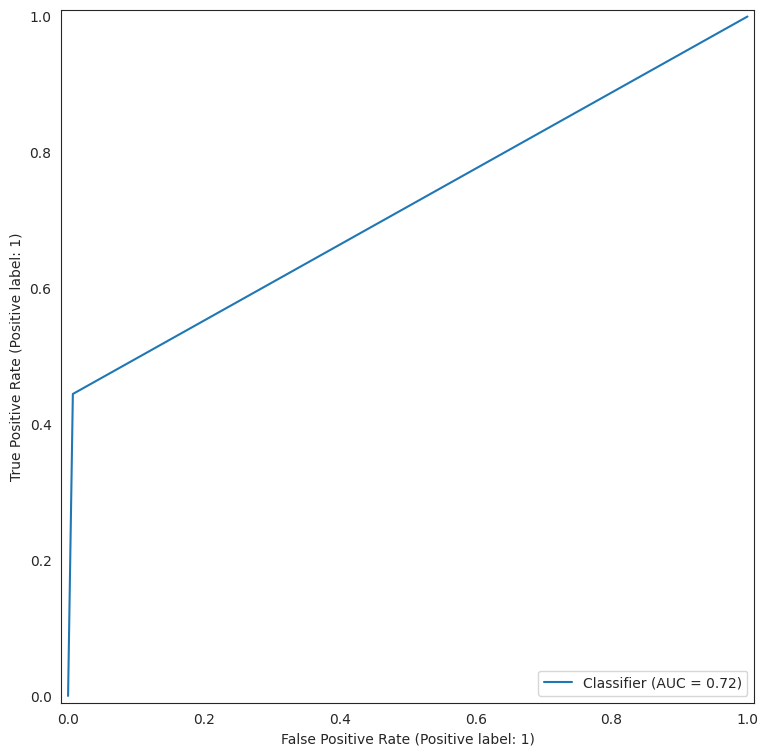

In [57]:
#ROC Curve
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_pred);

*Площадь под кривой всего 0.72. Кажется, можно лучше*

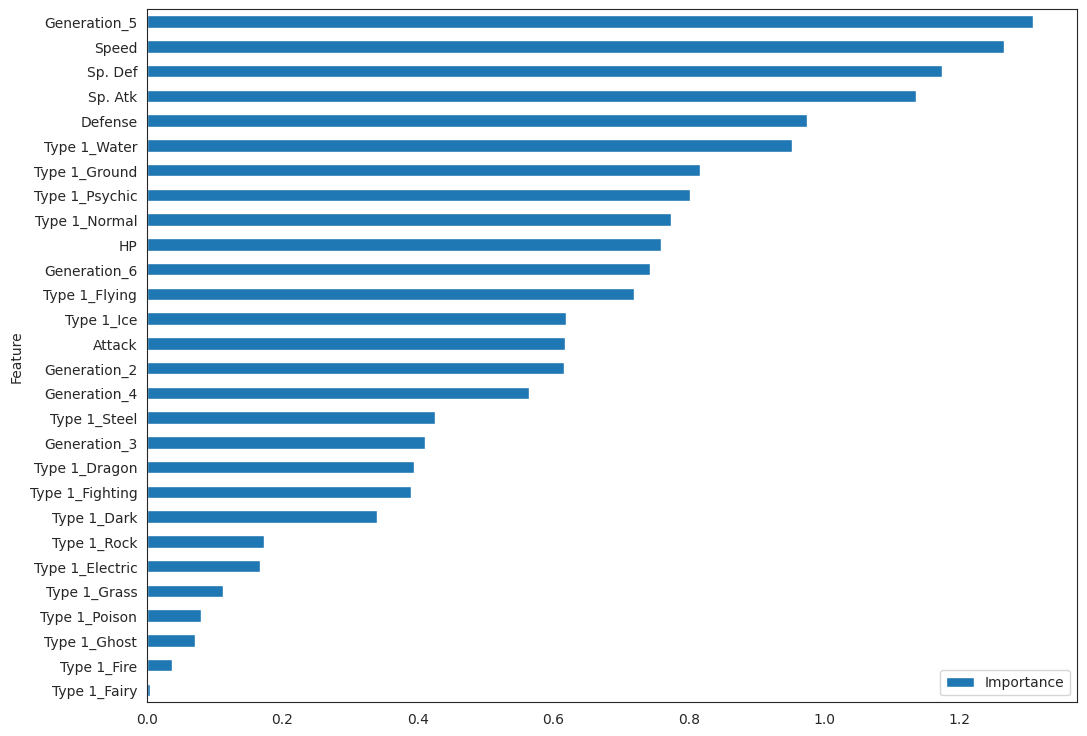

In [58]:
#важность признаков
coefficients = clf.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh');

*Самым важным оказалось то, относится ли к 5 поколению покемон и его скорость. Но я в покемонах не сильна и реально бы глянула что скажет модель без категориальных фичей. Потому что кажется, что физические способности должны определять легендарность. И вообще мы говорили, что много колонок с нулями это не оч хорошо для модели.*

Давайте глянем без категориальных:

In [59]:
pokemon = pd.read_csv("../data_folder/Pokemon.csv")
pokemon = pokemon.drop(['#', 'Name', 'Type 2', 'Total', 'Type 1', 'Generation'], axis = 1)
pokemon['Legendary'] = pokemon['Legendary'].astype(int)

X = pokemon.drop('Legendary', axis=1)
y = pokemon['Legendary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

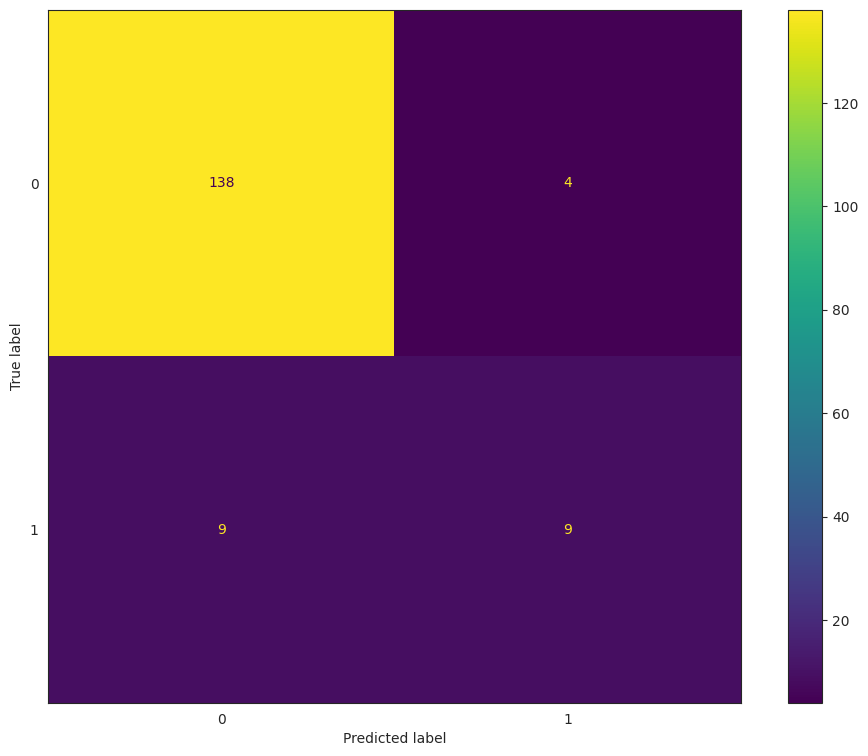

In [60]:
#confusion matrix
sns.set_style("white")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

*Много TN получилось опять. В целом все варианты не сильно изменились*

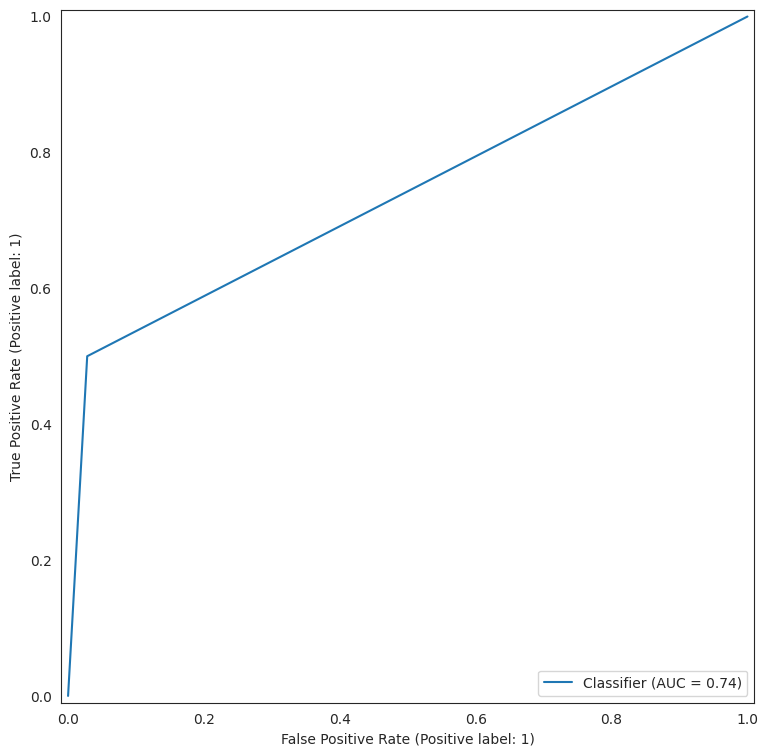

In [61]:
#ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred);

*Площадь под кривой увеличилась всего на 0.02. Не особо норм прирост*

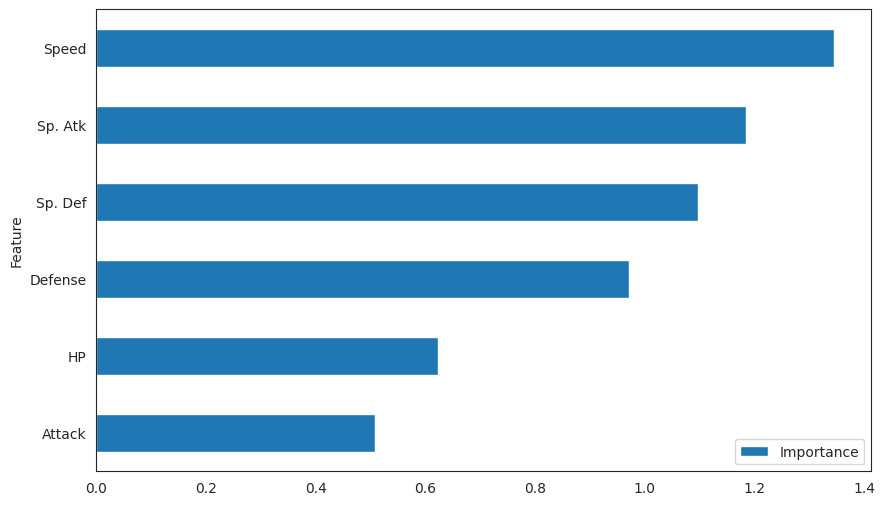

In [62]:
#важность признаков
coefficients = clf.coef_[0]
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

*Тут кстати получились коэффициенты соразмерные. Всё равно скорость важна. И специальные способности в топе.*

*В целом что с категориальными, что без. Кажется, не особенно модель лучше в каком-то случае*

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Любая вот ента: **My Darkest Days**. Совсем не помню, как наткнулась на неё во времена, когда училась в школе. А потом они распались. Но вокалист пошёл в Three Days Grace. Пробовала и их слушать, но место фаворита не вырвали.

ссылочки:
* [яндекс](https://music.yandex.ru/artist/239089)
* [vk](https://vk.com/artist/mydarkestdays)
* [spotify](https://open.spotify.com/artist/64g59lHsc4g2jMFokrKDGW?si=db5eSyJmQYqFyV73k3ee1w)
* [appleMusic](https://music.apple.com/us/artist/my-darkest-days/377449574?l=ru)

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

*Было норм. Но потому что на лекции разобрали материал хорошо (как и в прошлый раз). Всем проверяющим силы и прекрасного настроения. И чтобы модели были топ))*